# How to use Lompe for MI coupling

This notebooks shows how to use Lompe for solving the current continuity equation 

$j_u = \nabla \cdot J = \nabla \cdot (\Sigma_P\mathbf{E} + \Sigma_H(\mathbf{b}\times\mathbf{E}))$

where $j_u$ is the upward current density, and the right hand side refers to the height-integrated ionospehric current as described by the ionospheric Ohm's law. The problem we will solve is to **find $\mathbf{E}$ given $j_r$, $\Sigma_P$, and $\Sigma_H$**. We refer to this as "MI coupling" because this is how MHD models handle the coupling to the ionosphere. We will show that Lompe offers an alternative to the MHD models' ionospheric solvers.

As an example, we will use the $j_r$ given by the [AMPS model](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JA025387), an empirical model of the global ionospheric current system based on data from the CHAMP and Swarm satellites. We will use the Python module [pyamps](https://github.com/klaundal/pyamps) to calculate AMPS currents. pyamps can be installd with `pip install pyamps` 

We start by importing the necessary modules, and defining parameters used as input to the AMPS model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import lompe
from secsy import cubedsphere as cs
import pyamps
import datetime as dt

date = dt.datetime(2020, 7, 1, 13, 0) # will be used to infer dipole tilt and solar EUV conductance
By, Bz, vsw, f107 = 0, -4., 300., 100 # AMPS input parameters
Kp = 3 # this will be used to get a rough estimte of auroral conductance from the Hardy model

dipole = dipole.Dipole(date.year)
tilt = dipole.tilt(date)

a = pyamps.AMPS(vsw, By, Bz, tilt, f107)


Now we set up a cubed sphere grid that covers a large region, defined in dipole coordinates. We then calculate the MLT of the grid coordinates, which allows us to get $j_r$ from the `AMPS` object. We also use Lompe to make functions that calculate Hall and Pedersen conductance

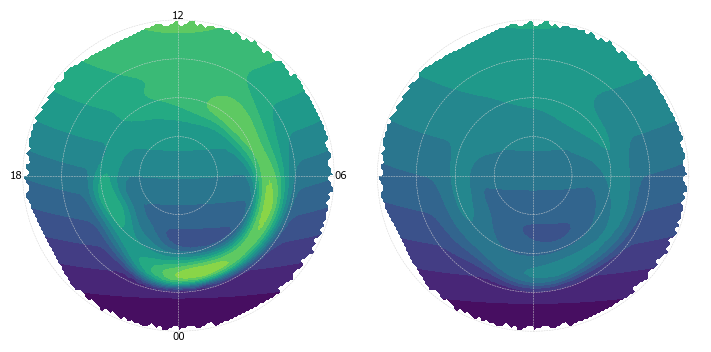

In [2]:
grid = cs.CSgrid(cs.CSprojection((0, 90), 0), 35000e3, 35000e3, 150e3, 150e3, R = (6371.2 + 110)*1e3)
grid.mlt = dipole.mlon2mlt(grid.lon, date) # use the dipole module to calculate MLT

# Make conductance functions (notice that the functions are called with dipole = True)
Hall     = lambda lon, lat: lompe.conductance.hardy_EUV(lon, lat, Kp, date, 'h', dipole = True)
Pedersen = lambda lon, lat: lompe.conductance.hardy_EUV(lon, lat, Kp, date, 'p', dipole = True)

# Plot the conductances:
fig, axes = plt.subplots(ncols = 2, figsize = (10, 5))
paxes = [lompe.Polarplot(ax) for ax in axes]
levels = np.linspace(0, 20, 15)
paxes[0].contourf(grid.lat, grid.mlt, Hall(grid.lon, grid.lat), levels = levels)
paxes[1].contourf(grid.lat, grid.mlt, Pedersen(grid.lon, grid.lat), levels = levels)
paxes[0].writeLTlabels(lat = paxes[0].minlat)
plt.tight_layout()

Now we set up the Lompe model object, add the radial current density as data, and run the inversion to get the Lompe model object

In [3]:
model = lompe.Emodel(grid, (Hall, Pedersen), dipole = True)

# Calculate the radial current density on the model.grid_J points:
lon, lat = model.grid_J.lon.flatten(), model.grid_J.lat.flatten()
mlt = dipole.mlon2mlt(lon, date)
jr = a.get_upward_current(lat, mlt) * 1e-6 # multiply by 1e-6 to get A/m^2 instead of microA/m^2
fac = lompe.Data(jr, np.vstack((lon, lat)), datatype = 'fac')
model.add_data(fac)

# Solve for the model vector:
model.run_inversion(l1 = 0, l2 = 0)
print('Model vector calculated')



(array([[ 3.42571500e-09, -2.83506531e-09, -7.60044778e-10, ...,
         -7.14477267e-11, -6.97130899e-11, -6.83862009e-11],
        [-2.83506531e-09,  3.59712373e-09,  7.66187765e-10, ...,
         -7.61511546e-11, -7.43767415e-11, -7.29842539e-11],
        [-7.60044778e-10,  7.66187765e-10,  1.49665261e-09, ...,
         -7.47266493e-11, -7.29541366e-11, -7.15370733e-11],
        ...,
        [-7.14477267e-11, -7.61511546e-11, -7.47266493e-11, ...,
          5.20635493e-09,  1.77054812e-09, -4.35325169e-09],
        [-6.97130899e-11, -7.43767415e-11, -7.29541366e-11, ...,
          1.77054812e-09,  1.09481724e-08, -1.05032634e-08],
        [-6.83862009e-11, -7.29842539e-11, -7.15370733e-11, ...,
         -4.35325169e-09, -1.05032634e-08,  1.39903078e-08]]),
 array([-4.44905538e-06, -4.52403165e-06, -4.54091522e-06, ...,
         2.93878260e-06,  2.80080082e-06,  2.09561580e-06]))

(10000, 1) (100, 100) (100, 100)


Text(0.5, 1.0, 'Ground $\\Delta B$ from AMPS\n(independent of conductance)')

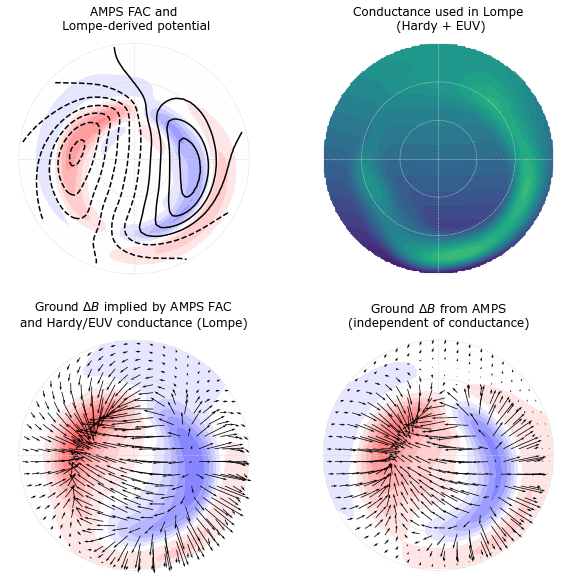

In [4]:
# Show the result:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 10))
paxes = [lompe.Polarplot(ax, minlat = 60) for ax in axes.flatten()]


faclevels = np.linspace(-1, 1, 22) * 1e-6
paxes[0].contourf(lat, mlt, jr, cmap = plt.cm.bwr, levels = faclevels)
pot = model.E_pot(lon, lat) * 1e-3 # convert to kV
paxes[0].contour(lat, mlt, pot, levels = np.r_[-200:200:3], colors = 'black') # 3 kV steps

# make a more high-resolution grid for displaying other quantities:
ampsmlat, ampsmlt = a.plotgrid_scalar
ampsmlon = dipole.mlt2mlon(ampsmlt, date)

paxes[1].contourf(ampsmlat, ampsmlt, Hall(ampsmlon, ampsmlat), levels = np.linspace(0, 25, 30))
paxes[1].contourf(ampsmlat, ampsmlt, Hall(ampsmlon, ampsmlat), levels = np.linspace(0, 25, 30))

Be, Bn, Bu = model.B_ground(ampsmlon, ampsmlat)
paxes[2].contourf(ampsmlat, ampsmlt, Bu * 1e9, levels = np.linspace(-200, 200, 22), cmap = plt.cm.bwr)

ampsmlat, ampsmlt = a.plotgrid_scalar
Bu = np.split(a.get_ground_Buqd(), 2)[0]
print(Bu.shape, ampsmlat.shape, ampsmlt.shape)
paxes[3].contourf(ampsmlat, ampsmlt, Bu, levels = np.linspace(-200, 200, 22), cmap = plt.cm.bwr)

# repeat, but plot vectors (using a different grid):
vmlat, vmlt = a.plotgrid_vector
vmlon = dipole.mlt2mlon(vmlt, date)
Be, Bn, Bu = model.B_ground(vmlon, vmlat)
paxes[2].quiver(vmlat, vmlt, Bn * 1e9, Be * 1e9, scale = 600)

Beqd, Bnqd = a.get_ground_perturbation(vmlat, vmlt)
paxes[3].quiver(vmlat, vmlt, Bnqd, Beqd, scale = 600)

# add labels
paxes[0].ax.set_title(u'AMPS FAC and\n Lompe-derived potential')
paxes[1].ax.set_title(u'Conductance used in Lompe\n (Hardy + EUV)')
paxes[2].ax.set_title(u'Ground $\Delta B$ implied by AMPS FAC \nand Hardy/EUV conductance (Lompe)')
paxes[3].ax.set_title(u'Ground $\Delta B$ from AMPS\n(independent of conductance)')

## Boundary conditions
In the above example, we did not impose any specific behaviour of the electric potential at low latitudes. We see that the potential contours are nevertheless well constrained within the region $>60^\circ$ but not exactly. With different FAC/conductance pattern, there may be a need to add some constraints to prevent the convection contours to "leak" away from the high latitudes. 

Ionospheric solvers in MHD simulations use a boundary condition that $\mathbf{E}\cdot\mathbf{t} = 0$ along some closed boundary (sometimes called Heppner-Maynard boundary) with tangent $\mathbf{t}$. Lompe currently does not include an option to impose such a condition exactly, but we can use synthetic data to give a "soft constraint". Below, we add synthetic data to keep the convection at high latitudes, adding to the example presented above.

(10000, 1) (100, 100) (100, 100)


Text(0.5, 1.0, 'Ground $\\Delta B$ from AMPS\n(independent of conductance)')

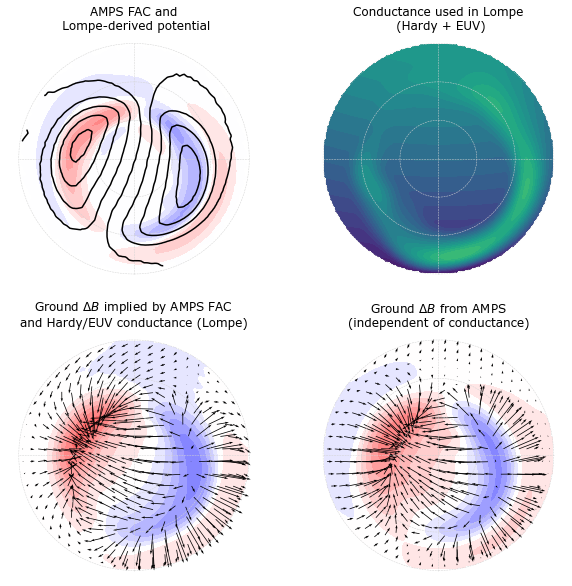

In [6]:
# The importance of the dataset in the inversion is controlled by the number of data points
# *and* by the 'scale' keyword. The scale normally should be set to a typical magnitude of the 
# data type, but here we set it artificially low to increase the importance of the boundary data
N = 100 # number of boundary points
#scale = 1e-4 # a typical electric field magnitude (DEPRECATED)
error = 1e-4 #give boundary condition low error
iweight = 1.0

blat = 60 # the boundary latitude
boundary_E = lompe.Data(np.vstack((np.zeros(N), np.zeros(N))), 
                        np.vstack((np.linspace(0, 360, N), np.full(N, blat))), 
                        datatype = 'Efield', error = error, iweight = iweight)


# add the boundary data and run the inversion again
model.add_data(boundary_E)
model.run_inversion(l1 = 0, l2 = 0)

# and now just copy all the code above to look at the difference
# Show the result:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 10))
paxes = [lompe.Polarplot(ax, minlat = 60) for ax in axes.flatten()]


faclevels = np.linspace(-1, 1, 22) * 1e-6
paxes[0].contourf(lat, mlt, jr, cmap = plt.cm.bwr, levels = faclevels)
pot = model.E_pot(lon, lat) * 1e-3 # convert to kV
paxes[0].contour(lat, mlt, pot, levels = np.r_[-200:200:3], colors = 'black') # 3 kV steps

# make a more high-resolution grid for displaying other quantities:
ampsmlat, ampsmlt = a.plotgrid_scalar
ampsmlon = dipole.mlt2mlon(ampsmlt, date)

paxes[1].contourf(ampsmlat, ampsmlt, Hall(ampsmlon, ampsmlat), levels = np.linspace(0, 25, 30))
paxes[1].contourf(ampsmlat, ampsmlt, Hall(ampsmlon, ampsmlat), levels = np.linspace(0, 25, 30))

Be, Bn, Bu = model.B_ground(ampsmlon, ampsmlat)
paxes[2].contourf(ampsmlat, ampsmlt, Bu * 1e9, levels = np.linspace(-200, 200, 22), cmap = plt.cm.bwr)

ampsmlat, ampsmlt = a.plotgrid_scalar
Bu = np.split(a.get_ground_Buqd(), 2)[0]
print(Bu.shape, ampsmlat.shape, ampsmlt.shape)
paxes[3].contourf(ampsmlat, ampsmlt, Bu, levels = np.linspace(-200, 200, 22), cmap = plt.cm.bwr)

# repeat, but plot vectors (using a different grid):
vmlat, vmlt = a.plotgrid_vector
vmlon = dipole.mlt2mlon(vmlt, date)
Be, Bn, Bu = model.B_ground(vmlon, vmlat)
paxes[2].quiver(vmlat, vmlt, Bn * 1e9, Be * 1e9, scale = 600)

Beqd, Bnqd = a.get_ground_perturbation(vmlat, vmlt)
paxes[3].quiver(vmlat, vmlt, Bnqd, Beqd, scale = 600)

# add labels
paxes[0].ax.set_title(u'AMPS FAC and\n Lompe-derived potential')
paxes[1].ax.set_title(u'Conductance used in Lompe\n (Hardy + EUV)')
paxes[2].ax.set_title(u'Ground $\Delta B$ implied by AMPS FAC \nand Hardy/EUV conductance (Lompe)')
paxes[3].ax.set_title(u'Ground $\Delta B$ from AMPS\n(independent of conductance)')

We see that the boundary data helped constrain the convection cells to the region poleward of $60^\circ$ like we wanted. But apart from that, the differences are small with this particular example. With real data, a boundary condition like this can help stabilize the solution. 